# Likelihood test

In [1]:
import copy
import jax 
print(f"GPU found? {jax.devices()}")
import jax.numpy as jnp
import numpy as np

from fiesta.inference.lightcurve_model import BullaLightcurveModel
from fiesta.inference.likelihood import EMLikelihood
from fiesta.inference.prior import Uniform, Composite
from fiesta.inference.injection import InjectionRecovery
from fiesta.utils import load_event_data

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

GPU found? [CudaDevice(id=0)]


Preamble

In [2]:
filters = ["ps1__g", "ps1__r", "ps1__i", "ps1__z", "ps1__y", "2massj", "2massh", "2massks", "sdssu"]
# trigger_time = 57982.5285236896 # TODO: needed for AT2017gfo, remove?
trigger_time = 0.0 

In [3]:
def nice_plot():
    pass

## Load the model

In [4]:
## Load the Bulla model and data
model = BullaLightcurveModel("Bu2022Ye",
                             "../trained_models/Bu2022Ye/",
                             filters)

2024-08-05 14:13:16.637181: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Create an injection

In [5]:
injection_dict = {"KNtheta": jnp.pi / 4,
                  "log10_mej_dyn": -2.5,
                  "vej_dyn": 0.15,
                  "Yedyn": 0.25,
                  "log10_mej_wind": -1.5,
                  "vej_wind": 0.1,
                  "luminosity_distance": 44.0,}

injection = InjectionRecovery(model, 
                              filters,
                              injection_dict)

injection.create_injection()

print("injection.data example")
print(injection.data[filters[0]])

print("shape of injection.data")
print(np.shape(injection.data[filters[0]]))

injection.data example
[[ 0.1        19.82460783  1.        ]
 [ 1.64444444 20.44383791  1.        ]
 [ 3.18888889 23.97484429  1.        ]
 [ 4.73333333 26.80807931  1.        ]
 [ 6.27777778 29.82901995  1.        ]
 [ 7.82222222 33.31812981  1.        ]
 [ 9.36666667 35.81188755  1.        ]
 [10.91111111 39.202695    1.        ]
 [12.45555556 42.28758946  1.        ]
 [14.         43.77586073  1.        ]]
shape of injection.data
(10, 3)


Plot the injection

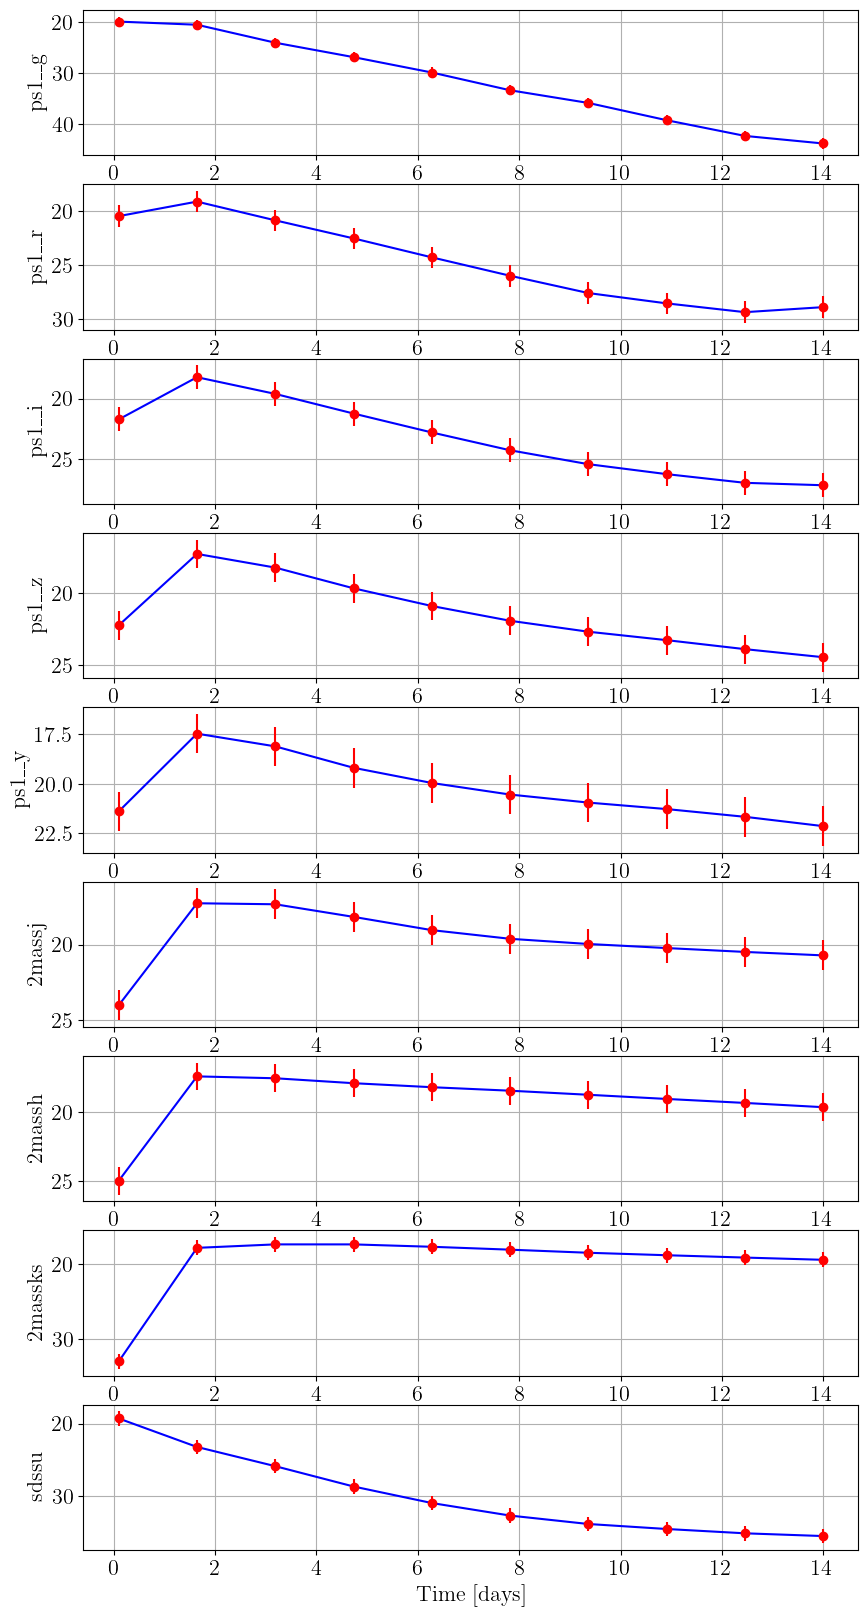

In [6]:
fig, ax = plt.subplots(nrows = len(filters), ncols = 1, figsize = (10, 20))

for i, filter_name in enumerate(filters):
    ax = plt.subplot(len(filters), 1, i + 1)
    
    # Load the data
    t, mag, err = injection.data[filter_name].T
    ax.plot(t, mag, color = "blue", label = "Model")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel(filter_name)
    ax.errorbar(t - trigger_time, mag, yerr = err, fmt = "o", color = "red", label = "Data")
    
    ax.invert_yaxis()
    
plt.show()

## Priors and likelihood objects initialization

In [7]:
inclination_EM      = Uniform(xmin=0.0, xmax=jnp.pi/2., naming=['KNtheta'])
log10_mej_dyn       = Uniform(xmin=-3.0, xmax=-1.7, naming=['log10_mej_dyn'])
vej_dyn             = Uniform(xmin=0.12, xmax=0.25, naming=['vej_dyn'])
Yedyn               = Uniform(xmin=0.15, xmax=0.3, naming=['Yedyn'])
log10_mej_wind      = Uniform(xmin=-2.0, xmax=-0.89, naming=['log10_mej_wind'])
vej_wind            = Uniform(xmin=0.03, xmax=0.15, naming=['vej_wind'])

prior_list = [inclination_EM, 
              log10_mej_dyn, 
              vej_dyn, 
              Yedyn, 
              log10_mej_wind, 
              vej_wind]

prior = Composite(prior_list)

likelihood = EMLikelihood(model,
                          filters,
                          injection.data,
                          fixed_params={"luminosity_distance": 44.0},
                          trigger_time=trigger_time)

Loading and preprocessing observations . . .


## Likelihood profiling

In [8]:
# # Generate some random samples
# N = 1_000
# key = jax.random.PRNGKey(0)

# log_probs = []
# log_likelihood = jax.jit(likelihood.log_likelihood)

# for i in range(N):
    
#     # Generate a new sample
#     key, subkey = jax.random.split(key)
#     samples = prior.sample(subkey, 1)
#     samples = {key: float(v[0]) for key, v in samples.items()}
    
#     # Get the log prob
#     value = log_likelihood(samples)
#     log_probs.append(value)
    
#     # Append the values
#     if i == 0:
#         param_values = np.array(list(samples.values()))
#     else:
#         these_values = np.array(list(samples.values()))
#         param_values = np.vstack([param_values, these_values])
        
# print(np.shape(param_values))
# print(np.shape(log_probs))

In [9]:
# idx, idy= 0, 3

# x, y = param_values[:, idx], param_values[:, idy]
# X, Y = np.meshgrid(x, y)

# log_probs = np.array(log_probs)
# log_probs_reshaped = log_probs.reshape(len(np.unique(y)), len(np.unique(x)))
# plt.contourf(x, y, log_probs_reshaped, levels=100)
# # plt.scatter(x, y, c=log_probs, s=5)
# plt.colorbar()
# plt.show()

In [11]:
# Get the masses array
for i in range(len(prior_list)):
    for j in range(i + 1, len(prior_list)):
        idx_1 = i
        idx_2 = j
        
        N = 20
        log_likelihood = jax.jit(likelihood.evaluate)

        xmin_1, xmax_1 = prior_list[idx_1].xmin, prior_list[idx_1].xmax
        xmin_2, xmax_2 = prior_list[idx_2].xmin, prior_list[idx_2].xmax

        name_1 = prior_list[idx_1].naming[0]
        name_2 = prior_list[idx_2].naming[0]

        params_1_array = jnp.linspace(xmin_1, xmax_1, N)
        params_2_array = jnp.linspace(xmin_2, xmax_2, N)
        P1, P2 = jnp.meshgrid(params_1_array, params_2_array)

        P1 = P1.reshape(-1)
        P2 = P2.reshape(-1)

        ll_array = []
        for p1, p2 in zip(P1, P2):
            params = copy.deepcopy(injection_dict)
            params[name_1] = p1
            params[name_2] = p2
            ll = log_likelihood(params)
            ll_array.append(ll)
            
        # Reshape
        P1_reshaped = P1.reshape(len(params_1_array), len(params_2_array))
        P2_reshaped = P2.reshape(len(params_1_array), len(params_2_array))
        ll_array_reshaped = jnp.array(ll_array).reshape(len(params_1_array), len(params_2_array))

        plt.contourf(P1_reshaped, P2_reshaped, ll_array_reshaped, levels=20)
        plt.axvline(injection_dict[name_1], color="red")
        plt.axhline(injection_dict[name_2], color="red")
        plt.xlabel(name_1)
        plt.ylabel(name_2)
        plt.colorbar()
        plt.grid(False)
        plt.savefig(f"./figures/likelihood_profiling_test_{name_1}_{name_2}.png")
        plt.close()